# ISBN Clustering

In [76]:
library(data.table)
library(foreach)
library(doParallel)
library(tidyverse)


Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel


In [77]:
registerDoParallel()

In [43]:
options(repr.plot.height=5)

In [73]:
db = src_postgres(dbname = 'openlib')

## Utilities

### Timed Messaging

This function takes a start time, and prints the time between start time and current time with the message.

In [32]:
xmsg = function(start, ...) {
    et = Sys.time() - start
    message(sprintf("[%8.2fs] ", as.double(et, units="secs")), ...)
}

## Clustering Algorithm

We cluster ISBNs by taking the bipartite graph of ISBNs and records, and computing the closure for each ISBN.  Each closure becomes a cluster with a single ‘book’ ID.

In [75]:
merge_clusters = function(...) {
    stack = bind_rows(...)
    stack %>% group_by(isbn) %>% 
        summarize(cluster=min(cluster)) %>%
        ungroup() %>%
        mutate(cluster=as.integer(cluster))
}

In [88]:
cluster_isbns = function(isbn_rec_tbl, bs=10000) {
    start = Sys.time()
    xmsg(start, "initializing clusters")
    clusters = isbn_rec_tbl %>% group_by(isbn) %>% summarize(cluster=min(record)) %>% ungroup()
    xmsg(start, "populating edges")
    edges = isbn_rec_tbl %>%
        rename(left_isbn = isbn) %>%
        inner_join(isbn_rec_tbl %>% rename(right_isbn = isbn)) %>%
        select(left_isbn, right_isbn) %>%
        distinct()
    xmsg(start, "clustering ", nrow(clusters), " with ", nrow(edges), " edges")
    # make blocks for parallelism
    #block_starts = seq(1, nrow(edges), bs)
    #block_ends = pmin(block_starts + (bs-1), nrow(edges))
    nchanged = length(isbn_rec_tbl)
    iter = 0
    while (nchanged > 0) {
        iter = iter + 1
        xmsg(start, "starting iteration ", iter)
        # propagate cluster IDs from left edges to right edges
        # new_clusters = foreach(start=block_starts, end=block_ends, .combine=merge_clusters, .multicombine=TRUE) %dopar% {
            # eblock = edges[start:end, ]
        new_clusters = clusters %>% rename(left_isbn = isbn) %>%
                inner_join(edges) %>%
                group_by(isbn=right_isbn) %>%
                summarize(cluster=min(cluster)) %>%
                ungroup()
        # }
        xmsg(start, "computing changed clusters")
        nchanged = new_clusters %>%
            inner_join(rename(clusters, old=cluster)) %>%
            mutate(changed = cluster != old) %>%
            pull(changed) %>%
            sum()
        clusters = new_clusters
        xmsg(start, "iteration ", iter, " changed ", nchanged, " clusters")
    }
    xmsg(start, "made ", length(unique(clusters$cluster)), " clusters in ", iter, " iterations")
    clusters
}

## Library of Congress

In [3]:
loc_rec_isbns = db %>% tbl('loc_isbn') %>% select(isbn, rec_id) %>% collect()
print(loc_rec_isbns)

[1] "tbl_df"     "tbl"        "data.frame"

[1] 6600638

In [5]:
loc_isbn_ids = loc_rec_isbns %>% select(isbn) %>% distinct() %>% mutate(id=1:n())
print(loc_isbn_ids)

# A tibble: 6,524,465 x 2
   isbn          id
   <chr>      <int>
 1 0687132924     1
 2 8473512243     2
 3 9682301084     3
 4 0316493953     4
 5 0202301575     5
 6 0912832177     6
 7 0675093686     7
 8 9686021086     8
 9 0716501864     9
10 0871622092    10
# ... with 6,524,455 more rows


In [10]:
loc_rec_edges = loc_rec_isbns %>% inner_join(loc_isbn_ids) %>% select(isbn=id, record=rec_id) %>% data.table()
print(loc_rec_edges)

Joining, by = "isbn"


            isbn  record
      1:       1 2784948
      2:       2 2784949
      3:       3 2784951
      4:       4 2784970
      5:       5 2784977
     ---                
6600634: 6524461 2784902
6600635: 6524462 2784903
6600636: 6524463 2784928
6600637: 6524464 2784936
6600638: 6524465 2784943


In [89]:
loc_clusters = cluster_isbns(loc_rec_edges)

[    0.00s] initializing clusters
[    7.57s] populating edges
Joining, by = "record"
[   19.00s] clustering 6524465 with 10491947 edges
[   19.00s] starting iteration 1
Joining, by = "left_isbn"
[   32.31s] computing changed clusters
Joining, by = "isbn"
[   35.09s] iteration 1 changed 23433 clusters
[   35.09s] starting iteration 2
Joining, by = "left_isbn"
[   47.10s] computing changed clusters
Joining, by = "isbn"
[   49.78s] iteration 2 changed 703 clusters
[   49.79s] starting iteration 3
Joining, by = "left_isbn"
[   63.98s] computing changed clusters
Joining, by = "isbn"
[   66.65s] iteration 3 changed 22 clusters
[   66.66s] starting iteration 4
Joining, by = "left_isbn"
[   80.48s] computing changed clusters
Joining, by = "isbn"
[   86.21s] iteration 4 changed 1 clusters
[   86.22s] starting iteration 5
Joining, by = "left_isbn"
[   99.35s] computing changed clusters
Joining, by = "isbn"
[  101.88s] iteration 5 changed 0 clusters
[  101.88s] made 5186987 clusters in 5 iterati

How big are our largest clusters?

In [86]:
cluster_sizes = loc_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
9927813,162
44464,129
7451086,123
2577188,116
6446243,98
7394785,84


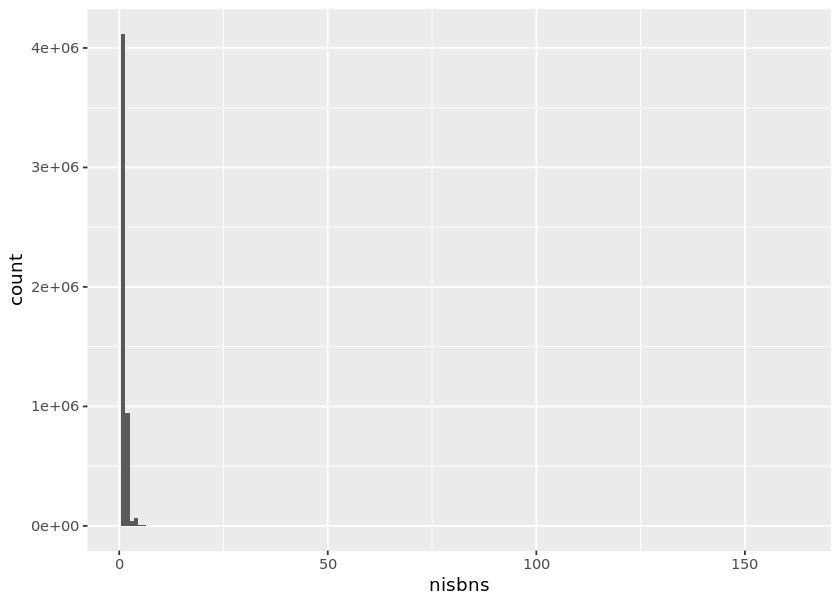

In [87]:
ggplot(cluster_sizes) +
    aes(x=nisbns) +
    geom_histogram(binwidth=1)

In [70]:
loc_clusters %>% rename(id=isbn) %>% inner_join(loc_isbn_ids) %>% select(isbn, cluster) %>%
    copy_to(db, ., name='loc_isbn_cluster', overwrite=TRUE, temporary=FALSE,
            unique_indexes=list("isbn"), indexes=list("cluster"))

Joining, by = "id"


## OpenLibrary

In [ ]:
ol_rec_edges = db %>% tbl('ol_isbn_link2') %>% select(isbn=isbn_id, record=book_code) %>% 
    collect()

In [74]:
print(ol_rec_edges)

# A tibble: 21,062,688 x 2
       isbn    record
 *    <int>     <int>
 1  1503099 105437266
 2  2659462 105437266
 3  5372388 112604572
 4 12702878 112604572
 5  2276794 102386629
 6  4327917 102386629
 7 15824799 105798955
 8 12504108 102066511
 9  8742366 102066511
10 10151017 110581121
# ... with 21,062,678 more rows


In [90]:
ol_clusters = cluster_isbns(ol_rec_edges)

[    0.00s] initializing clusters
[   59.45s] populating edges
Joining, by = "record"
[  437.96s] clustering 18404050 with 205979114 edges
[  437.97s] starting iteration 1
Joining, by = "left_isbn"
[  691.55s] computing changed clusters
Joining, by = "isbn"
[  699.67s] iteration 1 changed 1028071 clusters
[  699.68s] starting iteration 2
Joining, by = "left_isbn"
[  897.57s] computing changed clusters
Joining, by = "isbn"
[  904.87s] iteration 2 changed 111356 clusters
[  904.88s] starting iteration 3
Joining, by = "left_isbn"
[ 1084.15s] computing changed clusters
Joining, by = "isbn"
[ 1091.63s] iteration 3 changed 16333 clusters
[ 1091.63s] starting iteration 4
Joining, by = "left_isbn"
[ 1274.60s] computing changed clusters
Joining, by = "isbn"
[ 1282.12s] iteration 4 changed 6039 clusters
[ 1282.12s] starting iteration 5
Joining, by = "left_isbn"
[ 1461.77s] computing changed clusters
Joining, by = "isbn"
[ 1469.16s] iteration 5 changed 3677 clusters
[ 1469.17s] starting iteration

In [91]:
ol_cluster_sizes = ol_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
ol_cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
105077683,7520
100339351,6518
100004153,5178
107956464,4276
106611855,2820
100058368,2111


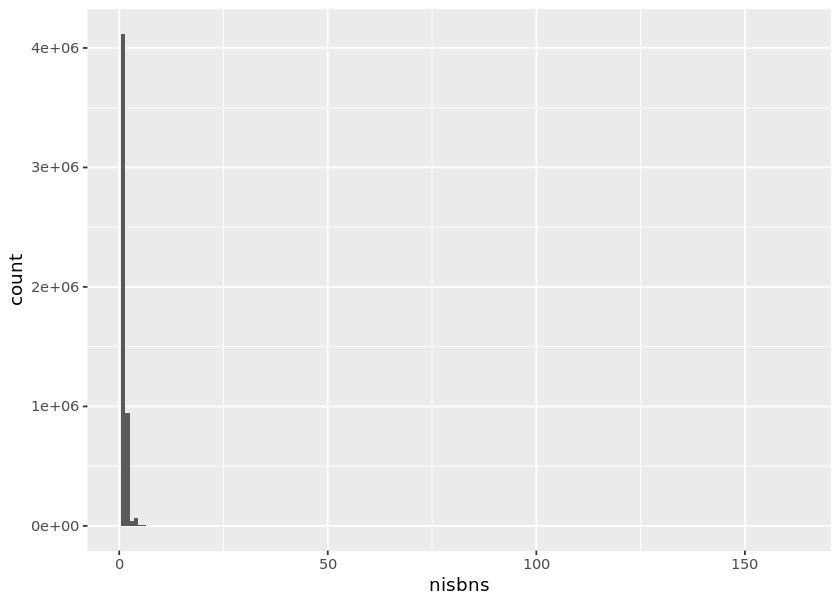

In [87]:
ggplot(ol_cluster_sizes) +
    aes(x=nisbns) +
    geom_histogram(binwidth=1)

In [92]:
ol_clusters %>% select(isbn_id=isbn, cluster) %>%
    copy_to(db, ., name='ol_isbn_cluster', overwrite=TRUE, temporary=FALSE,
            unique_indexes=list("isbn_id"), indexes=list("cluster"))